# 3. Modeling

In [383]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib 
import pickle

import tensorflow as tf
from keras.layers import *
from keras.regularizers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.text import *
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

import random
import os
random.seed(42)

In [558]:
new_df = pd.read_csv(os.path.join("..","..","data",'final_df.csv'))
new_df.head()

,locationId,place.name,category,rating,createdDate,is_fch,photonum,is_local,rated_count,average_photonum,average_rating,user_mean_rating,user_reviewcount,userID,category_l,land.addr
0,788542,마르코 폴로,EAT,5.0,20180314,0,0,1,20,0.05,3.95,4.363636,11,14256,1,서울 강남구 삼성동 159-1 트레이드타워 52층
1,788542,마르코 폴로,EAT,4.0,20171207,0,0,1,20,0.05,3.95,4.000000,6,722,1,서울 강남구 삼성동 159-1 트레이드타워 52층
2,788542,마르코 폴로,EAT,5.0,20161110,0,0,0,20,0.05,3.95,5.000000,1,30372,1,서울 강남구 삼성동 159-1 트레이드타워 52층
3,788542,마르코 폴로,EAT,3.0,20160611,0,0,0,20,0.05,3.95,4.250000,4,2116,1,서울 강남구 삼성동 159-1 트레이드타워 52층
4,788542,마르코 폴로,EAT,4.0,20151204,0,0,1,20,0.05,3.95,4.095238,42,3208,1,서울 강남구 삼성동 159-1 트레이드타워 52층


### 로컬 / 글로벌 데이터 분리

In [559]:
# 로컬 / 글로벌 데이터 분리
local_df = new_df.loc[new_df['is_local']==1]
global_df = new_df.loc[new_df['is_local']==0]
print('local_df shape:',local_df.shape, 'global_df shape :',global_df.shape)

local_df shape: (459903, 16) global_df shape : (93722, 16)


In [560]:
new_df['category'].value_counts()

EAT    496503
ACM     57122
Name: category, dtype: int64

In [561]:
local_df['category'].value_counts()

EAT    451133
ACM      8770
Name: category, dtype: int64

In [562]:
global_df['category'].value_counts()

ACM    48352
EAT    45370
Name: category, dtype: int64

In [563]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: # np.hstack([train[column], test[column]]): 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    # encoded_d = [vocab[i] for i in test[column]]
    
    return encoded, num, vocab

In [564]:
def trans_mul(vects):
    z = tf.reshape(vects,(-1,n_factors,1))
    return z 

def concat_shape2D(vects):
    a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11 = vects 
    z = tf.concat([a1,a2],axis=2)
    z = tf.concat([z,a3],axis=2)
    z = tf.concat([z,a4],axis=2)
    z = tf.concat([z,a5],axis=2)
    z = tf.concat([z,a6],axis=2)
    z = tf.concat([z,a7],axis=2)
    z = tf.concat([z,a8],axis=2)
    z = tf.concat([z,a9],axis=2)
    z = tf.concat([z,a10],axis=2)
    z = tf.concat([z,a11],axis=2)
    return z

def sum_layer(vects):
    a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11 = vects
    z = tf.add(a1,a2)
    z = tf.add(z,a3) 
    z = tf.add(z,a4)
    z = tf.add(z,a5)
    z = tf.add(z,a6)
    z = tf.add(z,a7)
    z = tf.add(z,a8)
    z = tf.add(z,a9)
    z = tf.add(z,a10)
    z = tf.add(z,a11)
    return z 

## 1. local_modeling

In [95]:
encoded_userID, num_userID, vocab_userID = get_data('userID', local_df) 

encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', local_df) 

encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', local_df) 

encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', local_df) 

encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', local_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', local_df) 
encoded_fch,  num_fch, vocab_fch = get_data('is_fch', local_df) 
encoded_category_l,  num_category_l, vocab_category_l = get_data('category_l', local_df) 

encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', local_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', local_df) 

encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', local_df) 

# Input Data

In [97]:
import tensorflow as tf 
print(tf.__version__)

2.1.0


In [98]:
n_factors = 8 
layers = [16,8, 4] 

# Input variables
userID = Input(shape=(1,), dtype='int64', name = 'userID') 

users_mean_rating = Input(shape=(1,), dtype='int64', name = 'users_mean_rating') 

user_reviewcount = Input(shape=(1,), dtype='int64', name = 'user_reviewcount') 

locationId = Input(shape=(1,), dtype='int64', name = 'locationId')
placeType = Input(shape=(1,), dtype='int64', name = 'placeType')

createdDate = Input(shape=(1,), dtype='int64', name = 'createdDate')
photonum = Input(shape=(1,), dtype='int64', name = 'photonum')

fch = Input(shape=(1,), dtype='int64', name = 'fch')
category_l = Input(shape=(1,), dtype='int64', name = 'category_l')
rated_count = Input(shape=(1,), dtype='int64', name = 'rated_count')
average_photonum = Input(shape=(1,), dtype='int64', name = 'average_photonum')
average_rating = Input(shape=(1,), dtype='int64', name = 'average_rating')

In [99]:
FM_userID = Embedding(input_dim = num_userID, output_dim = n_factors, 
                              name = 'FM_userID', input_length=1)(userID)

FM_users_mean_rating = Embedding(input_dim = num_users_mean_rating, output_dim = n_factors,
                              name = 'FM_users_mean_rating', input_length=1)(users_mean_rating)  

FM_user_reviewcount = Embedding(input_dim = num_user_reviewcount, output_dim = n_factors, 
                              name = 'FM_user_reviewcount', input_length=1)(user_reviewcount)

FM_locationId= Embedding(input_dim = num_locationId, output_dim = n_factors,
                              name = 'FM_locationId', input_length=1)(locationId)   

FM_createdDate = Embedding(input_dim = num_createdDate, output_dim = n_factors, 
                              name = 'FM_createdDate', input_length=1)(createdDate)
FM_photonum = Embedding(input_dim = num_photonum, output_dim = n_factors, 
                              name = 'FM_photonum', input_length=1)(photonum)

FM_fch = Embedding(input_dim = num_fch, output_dim = n_factors, 
                              name = 'FM_fch', input_length=1)(fch)
FM_category_l = Embedding(input_dim = num_category_l, output_dim = n_factors, 
                              name = 'FM_category_l', input_length=1)(category_l)
FM_rated_count = Embedding(input_dim = num_rated_count, output_dim = n_factors, 
                              name = 'FM_rated_count', input_length=1)(rated_count)
FM_average_photonum = Embedding(input_dim = num_average_photonum, output_dim = n_factors, 
                              name = 'FM_average_photonum', input_length=1)(average_photonum)
FM_average_rating = Embedding(input_dim = num_average_rating, output_dim = n_factors, 
                              name = 'FM_average_rating', input_length=1)(average_rating)

In [100]:
FM_userID_latent = Flatten()(FM_userID)
FM_userID_latent = Lambda(trans_mul)(FM_userID_latent)

FM_users_mean_rating_latent = Flatten()(FM_users_mean_rating)
FM_users_mean_rating_latent = Lambda(trans_mul)(FM_users_mean_rating_latent)

FM_user_reviewcount_latent = Flatten()(FM_user_reviewcount)
FM_user_reviewcount_latent = Lambda(trans_mul)(FM_user_reviewcount_latent)

FM_locationId_latent = Flatten()(FM_locationId)
FM_locationId_latent = Lambda(trans_mul)(FM_locationId_latent)

FM_createdDate_latent = Flatten()(FM_createdDate)
FM_createdDate_latent = Lambda(trans_mul)(FM_createdDate_latent)

FM_photonum_latent = Flatten()(FM_photonum)
FM_photonum_latent = Lambda(trans_mul)(FM_photonum_latent)

FM_fch_latent = Flatten()(FM_fch)
FM_fch_latent = Lambda(trans_mul)(FM_fch_latent)

FM_category_l_latent = Flatten()(FM_category_l)
FM_category_l_latent = Lambda(trans_mul)(FM_category_l_latent)

FM_rated_count_latent = Flatten()(FM_rated_count)
FM_rated_count_latent = Lambda(trans_mul)(FM_rated_count_latent)

FM_average_photonum_latent = Flatten()(FM_average_photonum)
FM_average_photonum_latent = Lambda(trans_mul)(FM_average_photonum_latent)

FM_average_rating_latent = Flatten()(FM_average_rating)
FM_average_rating_latent = Lambda(trans_mul)(FM_average_rating_latent)

FM_conv1d =Lambda(concat_shape2D)([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])


MF_part = Conv1D(128,kernel_size=1,activation='relu')(FM_conv1d)
MF_part = Flatten()(MF_part)

In [101]:
mlp_concat = Concatenate()([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])
mlp_concat = Flatten()(mlp_concat)

mlp_concat1 = Dense(layers[0], activation='relu', name=f"layer{0}")(mlp_concat) 
mlp_concat1 = Dense(layers[1], activation='relu', name=f"layer{1}")(mlp_concat1)
mlp_concat = Concatenate()([mlp_concat,mlp_concat1])
mlp_concat = Dense(layers[2],activation='relu')(mlp_concat)

In [102]:
# ! pip install pydot

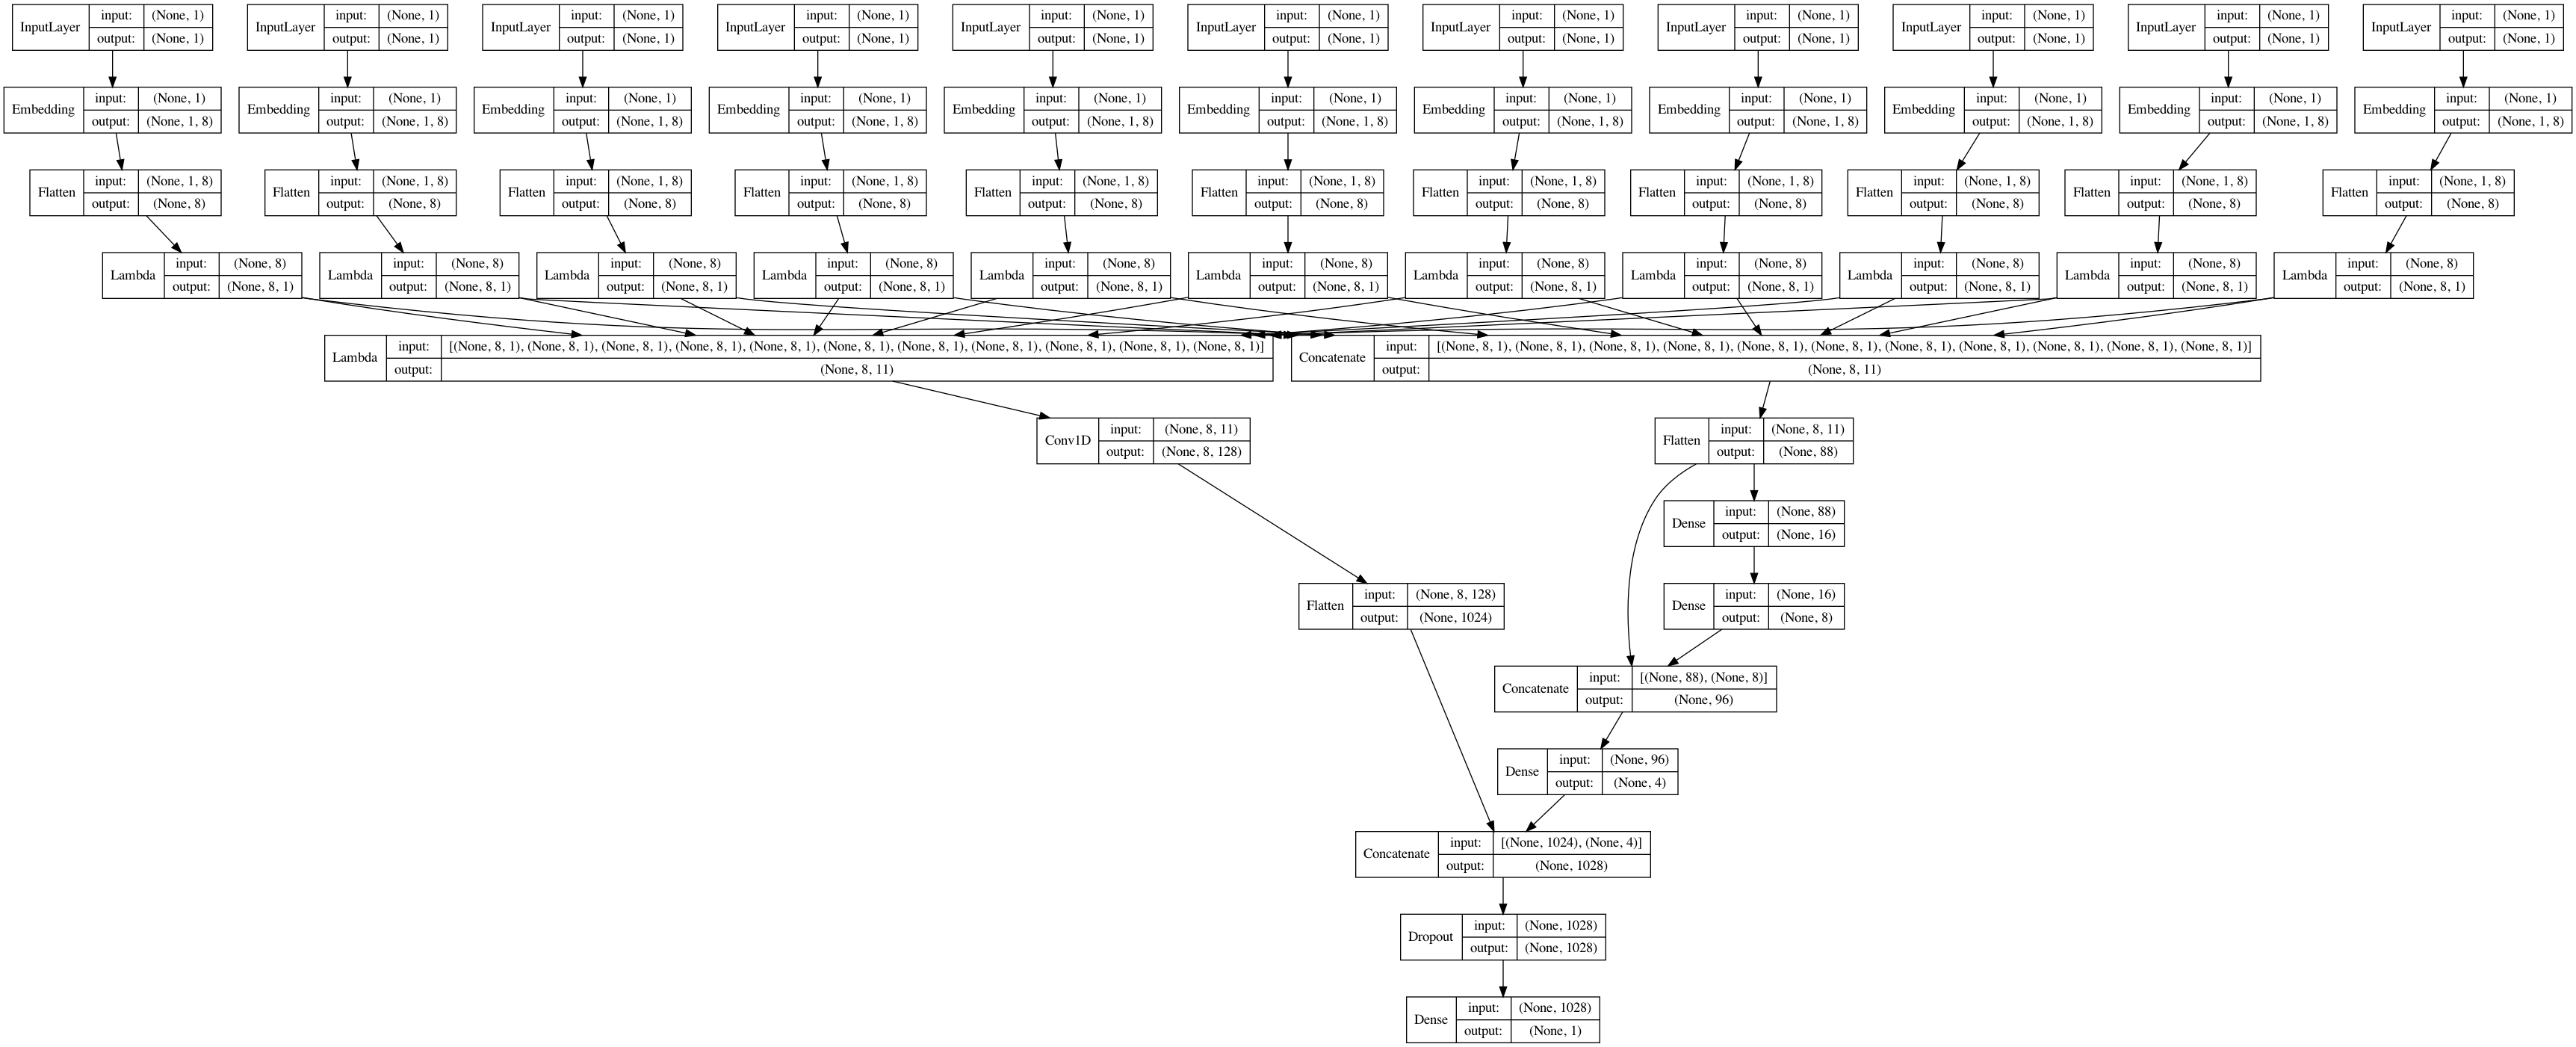

In [103]:
# Concatenate MF and MLP parts
predict_vector = Concatenate()([MF_part, mlp_concat])
predict_vector = Dropout(0.2)(predict_vector)

# Final prediction layer
prediction = Dense(1, name = "prediction")(predict_vector) # activation='sigmoid',
model = Model([userID, users_mean_rating, 
                             user_reviewcount, locationId, 
                             createdDate, photonum, fch, category_l, rated_count,
                                  average_photonum, average_rating], prediction)
model.compile(loss="mse", optimizer=RMSprop(lr=1e-4), metrics=[tf.keras.metrics.AUC()])

Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 422140 samples, validate on 2122 samples
Epoch 1/20
422140/422140 [==============================] - 11s 26us/step - loss: 16.8975 - auc_1: 0.0000e+00 - val_loss: 13.4539 - val_auc_1: 0.0000e+00
Epoch 2/20
422140/422140 [==============================] - 9s 22us/step - loss: 9.5022 - auc_1: 0.0000e+00 - val_loss: 4.7566 - val_auc_1: 0.0000e+00
Epoch 3/20
422140/422140 [==============================] - 9s 22us/step - loss: 1.5216 - auc_1: 0.0000e+00 - val_loss: 0.0805 - val_auc_1: 0.0000e+00
Epoch 4/20
422140/422140 [==============================] - 9s 22us/step - loss: 0.0619 - auc_1: 0.0000e+00 - val_loss: 0.0690 - val_auc_1: 0.0000e+00
Epoch 5/20
422140/422140 [==============================] - 9s 22us/step - loss: 0.0345 - auc_1: 0.0000e+00 - val_loss: 0.0395 - val_auc_1: 0.0000e+00
Epoch 6/20
422140/422140 [==============================] - 10s 23us/step - loss: 0.0208 - auc_1: 0.0000e+00 - val_loss: 0.0258 - val_auc_1: 0.0000e+00
Epoch 7/20
422140/422140 [==============

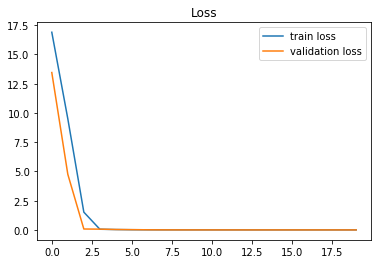

In [104]:
history = model.fit(x=[encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating],
                    y=local_df['place.rating'], batch_size=2048, epochs=20, validation_split=0.005, verbose=1)

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

# item 유사도 반환

In [105]:
def latent_to_vec(feature, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']

    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [112]:
from numpy import dot
from numpy.linalg import norm
import numpy as np


def cosim_id(df, item_id, top):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy()
    sim = []
    for i in range(len(vec)):
        if i != item_id:
            sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))
    new_vec['sim'] = sim
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    top_n = new_vec.head(top)['locationId'].tolist()
    if item_id in top_n:
        top_n.remove(item_id)
    return top_n

In [113]:
cosim_id(global_df, 299533, 10)

[13799101,
 13149943,
 19862391,
 12188440,
 4072704,
 19415260,
 4034835,
 37210781,
 8682064]

In [155]:
def sim_item(vec, df, item_id, top):
    
    top_id = cosim_id(vec, item_id, top)
    df = df.loc[df['locationId'].isin(top_id)]
    top_id = df.loc[df['category']== 'EAT'].drop_duplicates(['locationId'], keep='last')
    top_id = top_id.sort_values('average_rating', ascending=False)
    top_id = top_id['locationId'].unique().tolist()
    if len(top_id) == 0:
        print('해당 입력 호텔 정보가 없습니다.')
    else:
        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(top_id)):
            print('top',i+1,local_df.loc[local_df['locationId']==top_id[i]]['place.name'].unique()[0])

In [156]:
vec = latent_to_vec('FM_locationId', local_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])

sim_item(vec, local_df, 299533, 10)

input hotel: ibis styles Ambassador Seoul Gangnam
----------
top 1 김통
top 2 보름쇠
top 3 은행골
top 4 본가한방삼계탕
top 5 새마을식당 - 신사역점
top 6 왕십리순대국
top 7 브레드원
top 8 돈밸리
top 9 도이치하우스


In [157]:
sim_item(vec, local_df, 299152, 10)

input hotel: Best Western Premier Seoul Garden Hotel
----------
top 1 오레노라멘 인사점
top 2 서울신라호텔 패스트리부티크
top 3 크래프트아일랜드 강남역점
top 4 봉이돈가스
top 5 하타가야 삼성점
top 6 라운드어바웃 한남점
top 7 아찌떡볶이
top 8 궁중가마솥설렁탕
top 9 모스버거


## 2. global model

In [565]:
encoded_userID, num_userID, vocab_userID = get_data('userID', global_df) 

encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', global_df) 

encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', global_df) 

encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', global_df) 

encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', global_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', global_df) 
encoded_fch,  num_fch, vocab_fch = get_data('is_fch', global_df) 
encoded_category_l,  num_category_l, vocab_category_l = get_data('category_l', global_df) 

encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', global_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', global_df) 

encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', global_df) 

# Input Data

In [566]:
import tensorflow as tf 
print(tf.__version__)

2.1.0


In [567]:
n_factors = 8 
layers = [16,8, 4] 

# Input variables
userID = Input(shape=(1,), dtype='int64', name = 'userID') 

users_mean_rating = Input(shape=(1,), dtype='int64', name = 'users_mean_rating') 

user_reviewcount = Input(shape=(1,), dtype='int64', name = 'user_reviewcount') 

locationId = Input(shape=(1,), dtype='int64', name = 'locationId')
placeType = Input(shape=(1,), dtype='int64', name = 'placeType')

createdDate = Input(shape=(1,), dtype='int64', name = 'createdDate')
photonum = Input(shape=(1,), dtype='int64', name = 'photonum')

fch = Input(shape=(1,), dtype='int64', name = 'fch')
category_l = Input(shape=(1,), dtype='int64', name = 'category_l')
rated_count = Input(shape=(1,), dtype='int64', name = 'rated_count')
average_photonum = Input(shape=(1,), dtype='int64', name = 'average_photonum')
average_rating = Input(shape=(1,), dtype='int64', name = 'average_rating')

In [568]:
FM_userID = Embedding(input_dim = num_userID, output_dim = n_factors, 
                              name = 'FM_userID', input_length=1)(userID)

FM_users_mean_rating = Embedding(input_dim = num_users_mean_rating, output_dim = n_factors,
                              name = 'FM_users_mean_rating', input_length=1)(users_mean_rating)  

FM_user_reviewcount = Embedding(input_dim = num_user_reviewcount, output_dim = n_factors, 
                              name = 'FM_user_reviewcount', input_length=1)(user_reviewcount)

FM_locationId= Embedding(input_dim = num_locationId, output_dim = n_factors,
                              name = 'FM_locationId', input_length=1)(locationId)   

FM_createdDate = Embedding(input_dim = num_createdDate, output_dim = n_factors, 
                              name = 'FM_createdDate', input_length=1)(createdDate)
FM_photonum = Embedding(input_dim = num_photonum, output_dim = n_factors, 
                              name = 'FM_photonum', input_length=1)(photonum)

FM_fch = Embedding(input_dim = num_fch, output_dim = n_factors, 
                              name = 'FM_fch', input_length=1)(fch)
FM_category_l = Embedding(input_dim = num_category_l, output_dim = n_factors, 
                              name = 'FM_category_l', input_length=1)(category_l)
FM_rated_count = Embedding(input_dim = num_rated_count, output_dim = n_factors, 
                              name = 'FM_rated_count', input_length=1)(rated_count)
FM_average_photonum = Embedding(input_dim = num_average_photonum, output_dim = n_factors, 
                              name = 'FM_average_photonum', input_length=1)(average_photonum)
FM_average_rating = Embedding(input_dim = num_average_rating, output_dim = n_factors, 
                              name = 'FM_average_rating', input_length=1)(average_rating)

In [569]:
FM_userID_latent = Flatten()(FM_userID)
FM_userID_latent = Lambda(trans_mul)(FM_userID_latent)

FM_users_mean_rating_latent = Flatten()(FM_users_mean_rating)
FM_users_mean_rating_latent = Lambda(trans_mul)(FM_users_mean_rating_latent)

FM_user_reviewcount_latent = Flatten()(FM_user_reviewcount)
FM_user_reviewcount_latent = Lambda(trans_mul)(FM_user_reviewcount_latent)

FM_locationId_latent = Flatten()(FM_locationId)
FM_locationId_latent = Lambda(trans_mul)(FM_locationId_latent)

FM_createdDate_latent = Flatten()(FM_createdDate)
FM_createdDate_latent = Lambda(trans_mul)(FM_createdDate_latent)

FM_photonum_latent = Flatten()(FM_photonum)
FM_photonum_latent = Lambda(trans_mul)(FM_photonum_latent)

FM_fch_latent = Flatten()(FM_fch)
FM_fch_latent = Lambda(trans_mul)(FM_fch_latent)

FM_category_l_latent = Flatten()(FM_category_l)
FM_category_l_latent = Lambda(trans_mul)(FM_category_l_latent)

FM_rated_count_latent = Flatten()(FM_rated_count)
FM_rated_count_latent = Lambda(trans_mul)(FM_rated_count_latent)

FM_average_photonum_latent = Flatten()(FM_average_photonum)
FM_average_photonum_latent = Lambda(trans_mul)(FM_average_photonum_latent)

FM_average_rating_latent = Flatten()(FM_average_rating)
FM_average_rating_latent = Lambda(trans_mul)(FM_average_rating_latent)

FM_conv1d =Lambda(concat_shape2D)([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])


MF_part = Conv1D(128,kernel_size=1,activation='relu')(FM_conv1d)
MF_part = Flatten()(MF_part)

In [570]:
mlp_concat = Concatenate()([FM_userID_latent, FM_users_mean_rating_latent,
                             FM_user_reviewcount_latent, FM_locationId_latent,
                             FM_createdDate_latent, FM_photonum_latent,
                                  FM_fch_latent, FM_category_l_latent, FM_rated_count_latent,
                                  FM_average_photonum_latent, FM_average_rating_latent])
mlp_concat = Flatten()(mlp_concat)

mlp_concat1 = Dense(layers[0], activation='relu', name=f"layer{0}")(mlp_concat) 
mlp_concat1 = Dense(layers[1], activation='relu', name=f"layer{1}")(mlp_concat1)
mlp_concat = Concatenate()([mlp_concat,mlp_concat1])
mlp_concat = Dense(layers[2],activation='relu')(mlp_concat)

In [571]:
# ! pip install pydot

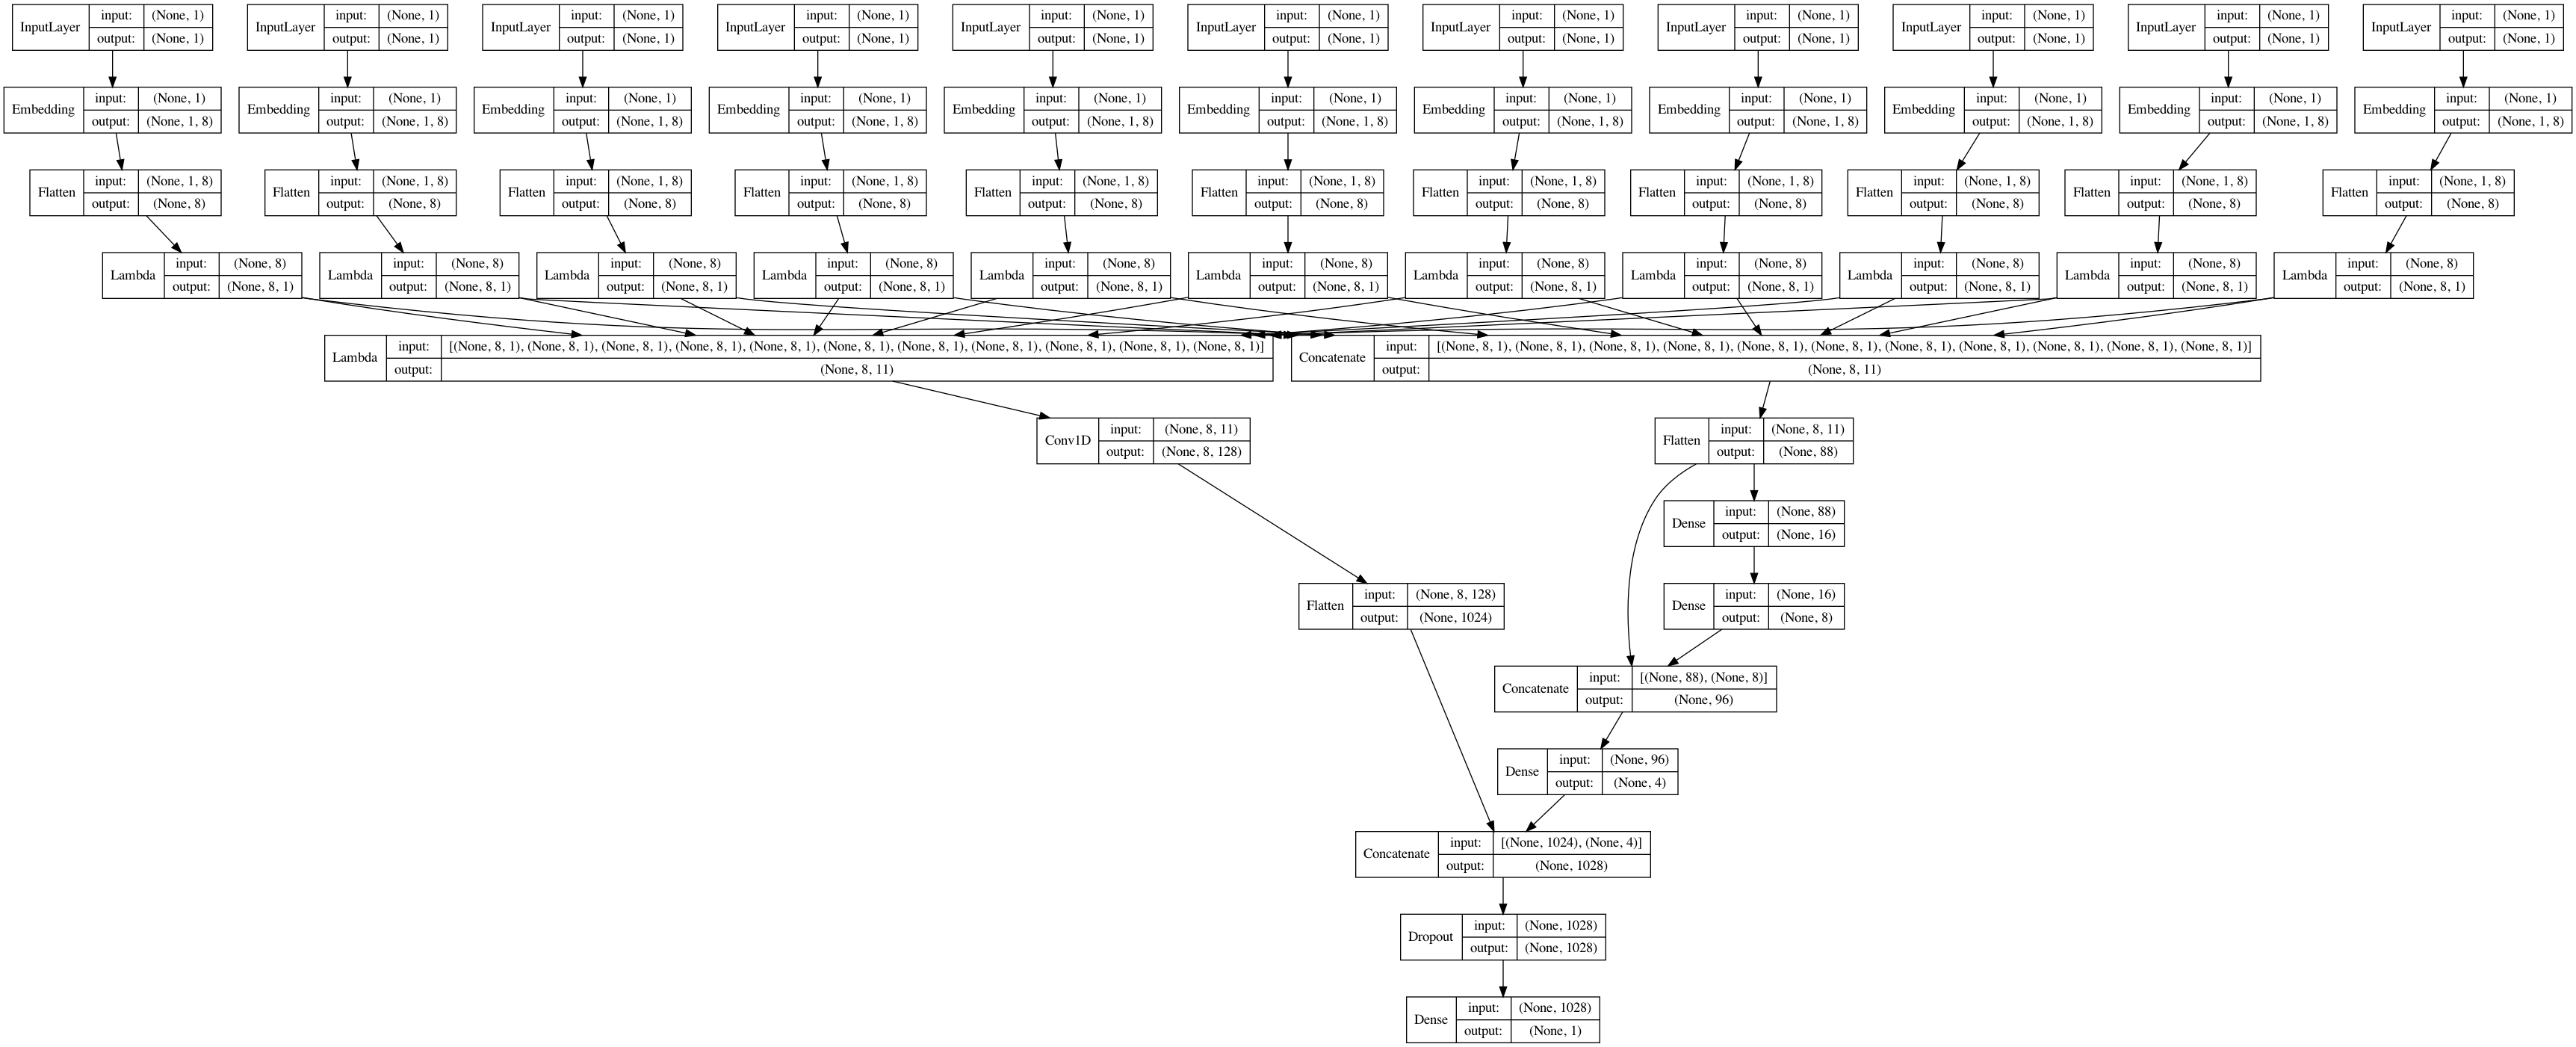

In [572]:
# Concatenate MF and MLP parts
predict_vector = Concatenate()([MF_part, mlp_concat])
predict_vector = Dropout(0.2)(predict_vector)

# Final prediction layer
prediction = Dense(1, name = "prediction")(predict_vector) # activation='sigmoid',
model = Model([userID, users_mean_rating, 
                             user_reviewcount, locationId, 
                             createdDate, photonum, fch, category_l, rated_count,
                                  average_photonum, average_rating], prediction)
model.compile(loss="mse", optimizer=RMSprop(lr=1e-4), metrics=[tf.keras.metrics.AUC()])

Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 93253 samples, validate on 469 samples
Epoch 1/20
93253/93253 [==============================] - 3s 34us/step - loss: 18.0556 - auc_3: 0.0000e+00 - val_loss: 14.0622 - val_auc_3: 0.0000e+00
Epoch 2/20
93253/93253 [==============================] - 2s 24us/step - loss: 17.2408 - auc_3: 0.0000e+00 - val_loss: 13.2556 - val_auc_3: 0.0000e+00
Epoch 3/20
93253/93253 [==============================] - 2s 23us/step - loss: 16.1894 - auc_3: 0.0000e+00 - val_loss: 12.2160 - val_auc_3: 0.0000e+00
Epoch 4/20
93253/93253 [==============================] - 2s 21us/step - loss: 14.8592 - auc_3: 0.0000e+00 - val_loss: 10.9376 - val_auc_3: 0.0000e+00
Epoch 5/20
93253/93253 [==============================] - 2s 24us/step - loss: 13.2514 - auc_3: 0.0000e+00 - val_loss: 9.4352 - val_auc_3: 0.0000e+00
Epoch 6/20
93253/93253 [==============================] - 2s 24us/step - loss: 11.3936 - auc_3: 0.0000e+00 - val_loss: 7.7570 - val_auc_3: 0.0000e+00
Epoch 7/20
93253/93253 [========================

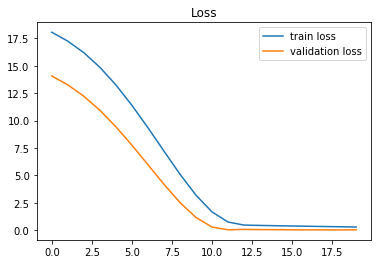

In [576]:
history = model.fit(x=[encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating],
                    y=global_df['rating'], batch_size=2048, epochs=20, validation_split=0.005, verbose=1)

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [577]:
# 모델 저장하기 
model.save_weights(os.path.join("..","..","data",'wnd_global_model.h5'))

model_json = model.to_json()
with open(os.path.join("..","..","data","wnd_global_model.json"), "w") as json_file : 
    json_file.write(model_json)
    
print("Saved model to disk")

Saved model to disk


# item 유사도 반환

In [578]:
# 모델 불러오기 
from keras.models import model_from_json 
json_file = open(os.path.join("..","..","data","wnd_global_model.json"), "r") 
loaded_model_json = json_file.read() 
json_file.close() 

loaded_model = model_from_json(loaded_model_json, custom_objects={'tf': tf, 'n_factors':8})

loaded_model.load_weights(os.path.join("..","..","data","wnd_global_model.h5"))
print("Loaded model from disk")

Loaded model from disk


In [579]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [580]:
vec = latent_to_vec('FM_locationId', loaded_model, global_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_fch, encoded_category_l, encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])

In [626]:
from numpy import dot
from numpy.linalg import norm
import numpy as np


def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 

In [627]:
cosim_id(global_df, vec, 3477158)

[9344455,
 12804718,
 6476950,
 3479249,
 7266651,
 13933996,
 4034730,
 9397742,
 4073556,
 11807527,
 4073668,
 8871059,
 9254937,
 13198869,
 13123529,
 7106360,
 15584738,
 7376273,
 9601891,
 4076019,
 9318693,
 16841536,
 4034133,
 4072982,
 9434826,
 12826504,
 9236024,
 3389355,
 9375697,
 10184287,
 8885282,
 9355458,
 3944202,
 1653156,
 7887345,
 8991046,
 4072240,
 4033697,
 13847230,
 8024262,
 8951058,
 4414123,
 10366158,
 4413998,
 9151611,
 4078323,
 4075035,
 8724369,
 4074059,
 7618195,
 4076363,
 8728063,
 12134634,
 4784018,
 4199087,
 7266524,
 7353876,
 7272229,
 4033013,
 8807219,
 5484695,
 12815119,
 10080270,
 14794821,
 4078432,
 1400141,
 1371740,
 8686013,
 12965733,
 3438914,
 4034984,
 4034584,
 6538761,
 3616594,
 4076063,
 9128129,
 6941988,
 9218411,
 15698264,
 9309234,
 3911536,
 9339466,
 4033433,
 10088494,
 11999142,
 9178994,
 3369503,
 4070597,
 9137882,
 9230491,
 9569770,
 9305077,
 9245191,
 9366659,
 5979688,
 3934385,
 8892619,
 9370202,
 

In [628]:
cosim_id(global_df, vec, 299533)

[10197261,
 2228907,
 3389031,
 7619069,
 13319648,
 3618350,
 7234261,
 5122587,
 9143967,
 9018227,
 1965082,
 12275263,
 9013700,
 3297967,
 3864340,
 9206047,
 9388447,
 18919612,
 3938967,
 11736500,
 12639450,
 4084256,
 1745760,
 9315046,
 7613319,
 8522933,
 4050019,
 15296756,
 7887355,
 650959,
 306126,
 9028016,
 7939849,
 7118396,
 12871134,
 9398699,
 8876923,
 4078180,
 1462343,
 2626435,
 8920925,
 4050121,
 6732796,
 9257343,
 7376507,
 4034979,
 6876823,
 5229279,
 8737552,
 7106369,
 1625995,
 8936991,
 3938673,
 4031188,
 4886861,
 9861024,
 6960514,
 2310251,
 9820385,
 4032500,
 6817357,
 3957242,
 8587809,
 8934825,
 4078666,
 16699907,
 19408101,
 3911379,
 10137453,
 8980089,
 9446807,
 9245843,
 3938807,
 4078657,
 982407,
 9245649,
 3336085,
 8532286,
 14066851,
 15764914,
 17143017,
 10379986,
 10211641,
 9218669,
 3687438,
 9287227,
 9037980,
 9358707,
 6498232,
 8964549,
 4050128,
 9035981,
 9152183,
 9449697,
 12946031,
 4031198,
 9109622,
 7776819,
 10732

In [644]:
global_df.loc[global_df['locationId']==10197261].category.values[0]== 'EAT'


True

In [661]:
import random

def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

In [662]:
sim_item(vec, global_df, 3477158, 10)

input hotel: Conrad Seoul
----------
top 1 오리지널팬케이크하우스
  주소 서울 강남구 강남대로162길 41
top 2 시그니엘 서울 더 라운지
  주소 서울 송파구 올림픽로 300 롯데월드타워 79층
top 3 영월
  주소 서울 서대문구 연희로 81-21
top 4 뱃고동
  주소 서울 강남구 언주로172길 54
top 5 샤이바나 - 광화문
  주소 서울 중구 세종대로 136
top 6 진고개
  주소 서울 충무로3가 30-16
top 7 장원각
  주소 서울 동호로 233-3
top 8 매화반점
  주소 서울 광진구 자양4동 4-11
top 9 곳간
  주소 서울 영등포구 여의대로 24 전경련회관 50층
top 10 모리
  주소 서울 서대문구 대현동 37-3


In [617]:
sim_item(vec, global_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [663]:
sim_item(vec, global_df, 299533, 10)

input hotel: ibis styles Ambassador Seoul Gangnam
----------
top 1 카페엣모스피어‬
  주소 서울 마포구 망원로 54-1
top 2 수연 산방
  주소 서울 성북구 성북동 248
top 3 빕스 명동중앙점
  주소 서울 중구 명동길 53
top 4 도셰프 논현점
  주소 서울 서초구 반포동 707-8
top 5 커피스미스
  주소 서울 강남대로92길 13
top 6 좋은세상만들기
  주소 서울 양평로12가길 14
top 7 불고기 브라더스 서울 파이낸스 센터점
  주소 서울 중구 태평로 1가 84번지 서울파이낸스센터 지하 2층 3호
top 8 톡톡
  주소 서울 강남구 도산대로51길 33 3층
top 9 고에몬
  주소 서울 서초대로77길 7
top 10 까페 마마스 시청점
  주소 서울 중구 무교동 19


In [664]:
sim_item(vec, global_df, 299152, 10)

input hotel: Best Western Premier Seoul Garden Hotel
----------
top 1 카페큐브 한옥카페
  주소 서울 중구 남대문로 11
top 2 모찌
  주소 서울 용산구 우사단로14길 11 ITW 호텔 1층
top 3 이품왕손만두
  주소 서울 성미산로 184
top 4 코리안덕
  주소 서울 명동10길 7
top 5 오프레
  주소 서울 서울 서초구 반포대로4길 12
top 6 밀크홀1937 - 종로점
  주소 서울 종로구 종로 86-1
top 7 단풍나무집 - 이태원점
  주소 서울 용산구 이태원로27가길 26
top 8 하카다분코
  주소 서울 마포구 독막로19길 43
top 9 앨리스 청담
  주소 서울 강남구 도산대로55길 47 지하1층
top 10 오스테리아꼬또
  주소 서울 종로 33


In [665]:
sim_item(vec, global_df, 6998634, 10)

input hotel: ibis budget Ambassador Seoul Dongdaemun
----------
top 1 마포갈비
  주소 서울 서초대로75길 36
top 2 슌미
  주소 서울 강남구 봉은사로 130 노보텔 앰배서더 서울 강남 LL층
top 3 맥파이 - 이태원점
  주소 서울 용산구 녹사평대로 244-1
top 4 신선설농탕 홍대점
  주소 서울 마포구 양화로 136
top 5 차이나팩토리
  주소 서울 강남대로 309
top 6 카페베네 공덕역점
  주소 서울 마포구 공덕동 423번지 b2호
top 7 곰국시집
  주소 서울 무교동 12-1
top 8 뚜레쥬르
  주소 서울 신흥로 89
top 9 서브웨이
  주소 서울 퇴계로 204
top 10 만랩커피 역삼래미안점
  주소 서울 강남구 선릉로69길 19 역삼래미안상가 1층 110호


In [666]:
sim_item(vec, global_df, 1796658, 10)

input hotel: Banyan Tree Club & Spa Seoul
----------
top 1 놀부 홍대점
  주소 서울 마포구 서교동 354-2
top 2 맥도날드 관훈점
  주소 서울 종로구 관훈동 198-42
top 3 창화당 - 익선동
  주소 서울 종로구 수표로28길 23
top 4 서울 베이킹 컴퍼니 - JW 메리어트 동대문 스퀘어 서울
  주소 서울 종로구 청계천로 279 JW 메리어트 동대문 스퀘어 서울 LL 층
top 5 이니스프리 그린카페
  주소 서울 중구 명동길 13
top 6 에피세리꼴라주
  주소 서울 한남대로20길 47-24
top 7 라따블
  주소 서울 중구 남대문로 78 이비스 앰배서더 서울 명동 19층
top 8 최대감네
  주소 서울 종로구 경운동 64-47 지상1층 1f
top 9 더심플한테이블
  주소 서울 독막로5길 32
top 10 송원
  주소 서울 중구 장충동2가 188-3


In [667]:
sim_item(vec, global_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 툭툭누들타이
  주소 서울 연희로 37
top 2 스타벅스 신촌점
  주소 서울 서대문구 창천동 18-55 즐거운 빌딩 1,2,3F Jeulgeoun Building 1,2,3F
top 3 진진바라 서초점
  주소 서울 서초구 서초대로 254 오퓨런스빌딩 B2
top 4 요수정
  주소 서울 광성로 28
top 5 자코비 버거
  주소 서울 용산구 용산동2가 45-6
top 6 호아빈
  주소 서울 명동7가길 20
top 7 르빵
  주소 서울 백제고분로41길 12
top 8 뜨리앙
  주소 서울 강남구 도산대로67길 30
top 9 붓처스컷 광화문점
  주소 서울 중구 세종대로 136
top 10 스시조
  주소 서울 소공로 106
